In [6]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, 
                             precision_recall_curve, confusion_matrix, average_precision_score)
import xgboost as xgb
import lightgbm as lgb
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import numpy as np
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from imblearn.combine import SMOTETomek, SMOTEENN
from collections import Counter

In [2]:
df = pd.read_csv(r"C:\Users\alefs\OneDrive\Documentos\LAPEI-CIGETS\GitHub\tcp\01_dados\data_mobilidade_v4.csv")

list(df)

['Unnamed: 0',
 'id',
 'id_seq',
 'transicao',
 'V1023',
 'idade',
 'genero',
 'VD3004',
 'V2010',
 'V2005',
 'UF',
 'qtd_pessoas',
 'periodo_ajust',
 'ensino_medio',
 'ensino_superior',
 'raça',
 'posicao_familiar',
 'tempo_desemprego',
 'filhos',
 'regiao',
 'renda_domiciliar',
 'renda_depois']

In [3]:
df_tratado = df.rename(columns={'V1023':'regiao_urbana','VD3004':'escolaridade','V2010':'cor','UF':'uf'})

df_tratado = df_tratado[['transicao','idade','escolaridade', 'genero', 'cor', 'qtd_pessoas',
                         'periodo_ajust', 'tempo_desemprego', 'uf',
                        'posicao_familiar', 'renda_domiciliar']]

bins = [0, 3, 5, 9, 21, float('inf')]
labels = ['Tempo de desemprego: muito baixo', 'Tempo de desemprego: baixo', 
          'Tempo de desemprego: mediano', 'Tempo de desemprego: alto', 'Tempo de desemprego: muito alto']
df_tratado['intervalo_desemprego'] = pd.cut(df_tratado['tempo_desemprego'], bins=bins, labels=labels, right=False)

df_tratado['transicao'] = df_tratado['transicao'].map({'Migrou para TCP': 1, 'Migrou para o setor privado': 0})

df_tratado = df_tratado.drop(columns = 'tempo_desemprego')

df_final = df_tratado[df_tratado['periodo_ajust'] == 'Pós-pandemia']

df_final.head(30).style

df_final.groupby('transicao').size().reset_index(name='count')

,transicao,count
0,0,619
1,1,161


In [4]:
def dividir(df):
    y = df[['transicao']]
    X = df.drop(columns=['transicao'])

    num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

    num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
    ])

    preprocessor = ColumnTransformer([
        ('num', num_pipeline, num_features),
        ('cat', cat_pipeline, cat_features)
    ])

    # Divisão dos dados em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=22)

    # Aplicar pré-processamento
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)

    # Aplicar balanceamento com SMOTE
    smote = SMOTE(random_state=5222)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_processed, y_train)

    return X_train_balanced, X_test_processed, y_train_balanced, y_test, preprocessor, X_train

In [7]:
x_train, x_test, y_train, y_test, preprocessor, x_train_raw1 = dividir(df_final)

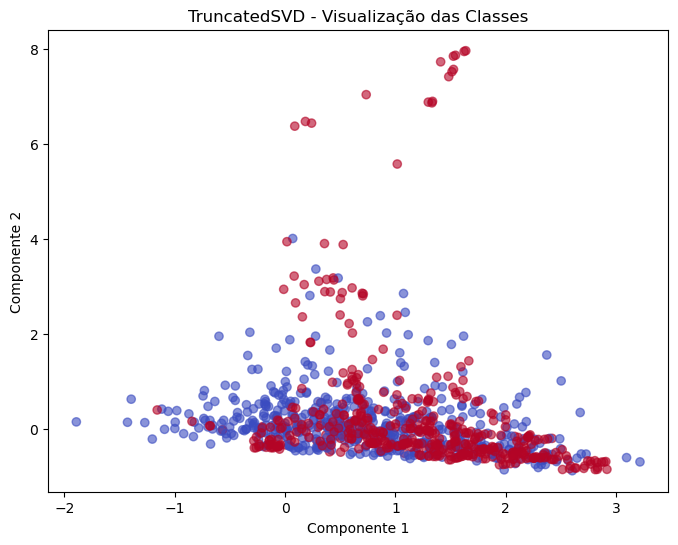

In [8]:
y_train_teste = y_train['transicao'].values
svd = TruncatedSVD(n_components=2, random_state=42)
x_svd = svd.fit_transform(x_train)

plt.figure(figsize=(8,6))
plt.scatter(x_svd[:,0], x_svd[:,1], c=y_train_teste, cmap='coolwarm', alpha=0.6)
plt.title('TruncatedSVD - Visualização das Classes')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.show()

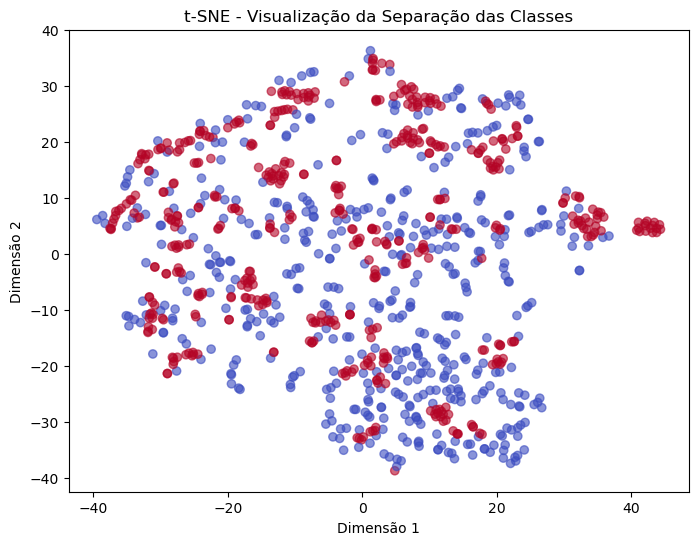

In [9]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, init='random')
X_tsne = tsne.fit_transform(x_train)

plt.figure(figsize=(8,6))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y_train_teste, cmap='coolwarm', alpha=0.6)
plt.title('t-SNE - Visualização da Separação das Classes')
plt.xlabel('Dimensão 1')
plt.ylabel('Dimensão 2')
plt.show()

In [11]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'LightGBM': lgb.LGBMClassifier(random_state=42)
}

# --- Função Objetivo para o Optuna (ATUALIZADA PARA PR AUC) ---
def objective(trial, model_name, x_train, y_train):
    """
    Função objetivo que o Optuna tentará maximizar.
    Usa validação cruzada para avaliar o desempenho de uma dada combinação de hiperparâmetros.
    """
    # A definição dos hiperparâmetros permanece a mesma
    if model_name == 'Logistic Regression':
        C = trial.suggest_float('C', 1e-2, 10, log=True)
        model = LogisticRegression(C=C, random_state=42, solver='liblinear')

    elif model_name == 'Decision Tree':
        max_depth = trial.suggest_int('max_depth', 3, 15)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
        model = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=42)

    elif model_name == 'Random Forest':
        n_estimators = trial.suggest_int('n_estimators', 100, 1000, step=100)
        max_depth = trial.suggest_int('max_depth', 5, 20)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=42)

    elif model_name == 'XGBoost':
        n_estimators = trial.suggest_int('n_estimators', 100, 1000, step=100)
        max_depth = trial.suggest_int('max_depth', 3, 9)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
        subsample = trial.suggest_float('subsample', 0.6, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.6, 1.0)
        gamma = trial.suggest_float('gamma', 0, 1.0)
        model = xgb.XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, subsample=subsample, colsample_bytree=colsample_bytree, gamma=gamma, use_label_encoder=False, eval_metric='logloss', random_state=42)

    elif model_name == 'LightGBM':
        n_estimators = trial.suggest_int('n_estimators', 100, 1000, step=100)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
        num_leaves = trial.suggest_int('num_leaves', 20, 100)
        min_child_samples = trial.suggest_int('min_child_samples', 5, 50)
        model = lgb.LGBMClassifier(n_estimators=n_estimators, learning_rate=learning_rate, num_leaves=num_leaves, min_child_samples=min_child_samples, random_state=42)

    # Para garantir a reprodutibilidade da validação cruzada
    cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # **MUDANÇA PRINCIPAL AQUI**
    # A métrica agora é 'average_precision', que corresponde à área sob a curva Precision-Recall.
    score = cross_val_score(model, x_train, y_train, cv=cv_splitter, scoring='average_precision', n_jobs=-1) # <-- MUDANÇA AQUI

    # Retorna a média das pontuações dos folds
    return score.mean()

# --- Função Principal de Treinamento e Avaliação (ATUALIZADA) ---
def treinando_avaliando_optuna(x_train, y_train, x_test, y_test):
    """
    Orquestra a otimização com Optuna e a avaliação final.
    """
    best_models = {}

    for name in models.keys():
        print(f"Otimizando o modelo: {name}")
        func = lambda trial: objective(trial, name, x_train, y_train)
        study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42))
        study.optimize(func, n_trials=20)
        print(f"Melhores parâmetros para {name}: {study.best_params}\n")

        best_model_class = models[name].__class__
        best_params = study.best_params
        
        # Ajustes especiais para modelos que não aceitam todos os parâmetros no construtor
        if name == 'Logistic Regression':
            best_params['solver'] = 'liblinear'
        
        best_model = best_model_class(**best_params, random_state=42)
        
        if name in ['XGBoost']:
            best_model = xgb.XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss', random_state=42)
        
        best_model.fit(x_train, y_train)
        best_models[name] = best_model

    # Avaliação no conjunto de teste (RELATÓRIO ATUALIZADO)
    results = []
    for name, model in best_models.items():
        y_pred = model.predict(x_test)
        y_prob = model.predict_proba(x_test)[:, 1]
        results.append({
            'Model': name,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1 Score': f1_score(y_test, y_pred),
            'ROC AUC': roc_auc_score(y_test, y_prob),
            'PR AUC': average_precision_score(y_test, y_prob) # <-- MÉTRICA ADICIONADA AO RELATÓRIO
        })

    # Converte para DataFrame para melhor visualização
    return results, best_models

In [12]:
results_df, final_models = treinando_avaliando_optuna(x_train, y_train, x_test, y_test)
results_m1_df = pd.DataFrame(results_df)
print(results_m1_df.sort_values(by = 'ROC AUC', ascending = False))

[I 2025-06-25 13:14:02,565] A new study created in memory with name: no-name-11475663-f9b0-4ffa-b412-8417cef2fcfa


Otimizando o modelo: Logistic Regression


[I 2025-06-25 13:14:04,204] Trial 0 finished with value: 0.723018322182423 and parameters: {'C': 0.13292918943162169}. Best is trial 0 with value: 0.723018322182423.
[I 2025-06-25 13:14:05,225] Trial 1 finished with value: 0.7197457365019029 and parameters: {'C': 7.114476009343421}. Best is trial 0 with value: 0.723018322182423.
[I 2025-06-25 13:14:06,116] Trial 2 finished with value: 0.7224099506169426 and parameters: {'C': 1.5702970884055387}. Best is trial 0 with value: 0.723018322182423.
[I 2025-06-25 13:14:06,141] Trial 3 finished with value: 0.7246133812963181 and parameters: {'C': 0.6251373574521749}. Best is trial 3 with value: 0.7246133812963181.
[I 2025-06-25 13:14:06,165] Trial 4 finished with value: 0.7107386245868534 and parameters: {'C': 0.02938027938703535}. Best is trial 3 with value: 0.7246133812963181.
[I 2025-06-25 13:14:06,197] Trial 5 finished with value: 0.7107386245868534 and parameters: {'C': 0.029375384576328288}. Best is trial 3 with value: 0.7246133812963181.

Melhores parâmetros para Logistic Regression: {'C': 0.32370955146681896}

Otimizando o modelo: Decision Tree


[I 2025-06-25 13:14:06,928] Trial 2 finished with value: 0.7428466736168909 and parameters: {'max_depth': 3, 'min_samples_split': 18, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.8300686920377871.
[I 2025-06-25 13:14:07,011] Trial 3 finished with value: 0.8224154633840917 and parameters: {'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8300686920377871.
[I 2025-06-25 13:14:07,096] Trial 4 finished with value: 0.8075650534262664 and parameters: {'max_depth': 13, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8300686920377871.
[I 2025-06-25 13:14:07,179] Trial 5 finished with value: 0.8074346777345621 and parameters: {'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.8300686920377871.
[I 2025-06-25 13:14:07,262] Trial 6 finished with value: 0.8353908021864805 and parameters: {'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 7}. Best is trial 6 wit

Melhores parâmetros para Decision Tree: {'max_depth': 9, 'min_samples_split': 16, 'min_samples_leaf': 5}

Otimizando o modelo: Random Forest


[I 2025-06-25 13:14:08,769] Trial 0 finished with value: 0.9432938487866409 and parameters: {'n_estimators': 400, 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9432938487866409.
[I 2025-06-25 13:14:09,207] Trial 1 finished with value: 0.913294851775602 and parameters: {'n_estimators': 200, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9432938487866409.
[I 2025-06-25 13:14:10,553] Trial 2 finished with value: 0.9319828332514662 and parameters: {'n_estimators': 700, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9432938487866409.
[I 2025-06-25 13:14:12,167] Trial 3 finished with value: 0.9393968774329166 and parameters: {'n_estimators': 900, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.9432938487866409.
[I 2025-06-25 13:14:13,020] Trial 4 finished with value: 0.9517823346390308 and parameters: {'n

Melhores parâmetros para Random Forest: {'n_estimators': 800, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 1}



[I 2025-06-25 13:14:35,268] A new study created in memory with name: no-name-785124de-9026-4dd5-b8e1-5dc594f38c99


Otimizando o modelo: XGBoost


[I 2025-06-25 13:14:35,562] Trial 0 finished with value: 0.9447159864742867 and parameters: {'n_estimators': 400, 'max_depth': 9, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'gamma': 0.15599452033620265}. Best is trial 0 with value: 0.9447159864742867.
[I 2025-06-25 13:14:35,710] Trial 1 finished with value: 0.9456577764405207 and parameters: {'n_estimators': 100, 'max_depth': 9, 'learning_rate': 0.07725378389307355, 'subsample': 0.8832290311184181, 'colsample_bytree': 0.608233797718321, 'gamma': 0.9699098521619943}. Best is trial 1 with value: 0.9456577764405207.
[I 2025-06-25 13:14:36,157] Trial 2 finished with value: 0.9438203935950515 and parameters: {'n_estimators': 900, 'max_depth': 4, 'learning_rate': 0.01855998084649059, 'subsample': 0.6733618039413735, 'colsample_bytree': 0.7216968971838151, 'gamma': 0.5247564316322378}. Best is trial 1 with value: 0.9456577764405207.
[I 2025-06-25 13:14:36,466] Trial 3 finished

Melhores parâmetros para XGBoost: {'n_estimators': 600, 'max_depth': 9, 'learning_rate': 0.01351182947645082, 'subsample': 0.6783931449676581, 'colsample_bytree': 0.6180909155642152, 'gamma': 0.32533033076326434}



[I 2025-06-25 13:14:42,292] A new study created in memory with name: no-name-204396b3-8a7e-445c-a4f6-9ab76a5c23df


Otimizando o modelo: LightGBM


[I 2025-06-25 13:14:43,981] Trial 0 finished with value: 0.9354951781628325 and parameters: {'n_estimators': 400, 'learning_rate': 0.2536999076681772, 'num_leaves': 79, 'min_child_samples': 32}. Best is trial 0 with value: 0.9354951781628325.
[I 2025-06-25 13:14:45,355] Trial 1 finished with value: 0.9173065863617632 and parameters: {'n_estimators': 200, 'learning_rate': 0.01699897838270077, 'num_leaves': 24, 'min_child_samples': 44}. Best is trial 0 with value: 0.9354951781628325.
[I 2025-06-25 13:14:46,835] Trial 2 finished with value: 0.9360956160873712 and parameters: {'n_estimators': 700, 'learning_rate': 0.11114989443094977, 'num_leaves': 21, 'min_child_samples': 49}. Best is trial 2 with value: 0.9360956160873712.
[I 2025-06-25 13:14:49,511] Trial 3 finished with value: 0.9458615551089204 and parameters: {'n_estimators': 900, 'learning_rate': 0.020589728197687916, 'num_leaves': 34, 'min_child_samples': 13}. Best is trial 3 with value: 0.9458615551089204.
[I 2025-06-25 13:14:50,7

Melhores parâmetros para LightGBM: {'n_estimators': 900, 'learning_rate': 0.037217878553171685, 'num_leaves': 87, 'min_child_samples': 5}

[LightGBM] [Info] Number of positive: 492, number of negative: 492
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000741 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1259
[LightGBM] [Info] Number of data points in the train set: 984, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

                 Model  Accuracy  Precision   Recall  F1 Score   ROC AUC  \
0  Logistic Regression  0.685897   0.311111  0.43750  0.363636  0.626512   
2        Random Forest  0.775641   0.411765  0.21875  0.285714  0.621472   
3              XGBoost  0.769231   0.357143  0.15625  0.217391  0.608367   
4             LightGBM  0.756410   0.363636  0.25000  0.296296  0.593750   
1        Decision Tree  0.615385   0.111111  0.12500  0.117647  0.467868   

     PR AUC  
0  0.281618  
2  0.301732  
3  0.307760  
4  0.286773  
1  0.187744  


In [13]:
#Identificando o nome do algoritmo com a melhor ROC AUC
best_model_name = results_m1_df.sort_values(by='PR AUC', ascending=False).iloc[0]['Model']

#Recuperando o algoritmo com base no nome do algoritmo
best_model_m1 = final_models[best_model_name]

C:\Users\alefs\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [13:16:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Melhor limiar: 0.4136652648448944 com F1 Score: 0.9847405900305188


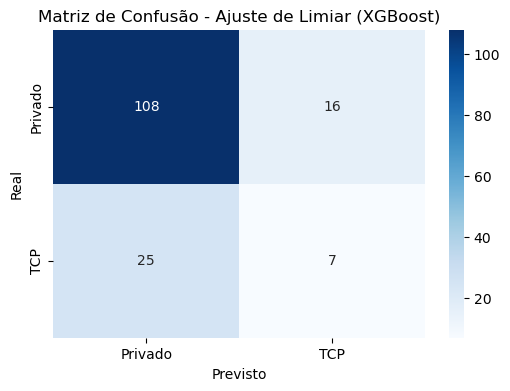

In [14]:
# Treine o modelo
best_model_m1.fit(x_train, y_train)

# Calcular probabilidades e encontrar o melhor limiar baseado no F1 Score
y_prob_train = best_model_m1.predict_proba(x_train)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_train, y_prob_train)

best_threshold, best_f1 = max(((threshold, f1_score(y_train, (y_prob_train >= threshold).astype(int))) for threshold in thresholds), key=lambda x: x[1])

print(f"Melhor limiar: {best_threshold} com F1 Score: {best_f1}")

# Ajustar previsões no conjunto de teste
y_pred_adjusted = (best_model_m1.predict_proba(X=x_test)[:, 1] >= best_threshold).astype(int)

# Matriz de Confusão
cm_adjusted = confusion_matrix(y_test, y_pred_adjusted)

# Exibição da Matriz de Confusão
plt.figure(figsize=(6, 4))
sns.heatmap(cm_adjusted, annot=True, fmt='d', cmap='Blues', xticklabels=['Privado', 'TCP'], yticklabels=['Privado', 'TCP'])
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title(f'Matriz de Confusão - Ajuste de Limiar ({best_model_name})')
plt.show()

In [15]:
print("ROC AUC: ", roc_auc_score(y_test, y_pred_adjusted))
print("Precision: ", precision_score(y_test, y_pred_adjusted))
print("Accuracy: ", accuracy_score(y_test, y_pred_adjusted))
print("Recall: ", recall_score(y_test, y_pred_adjusted))
print("F1 Score: ", f1_score(y_test, y_pred_adjusted))
print('PR AUC', average_precision_score(y_test, y_pred_adjusted))

ROC AUC:  0.544858870967742
Precision:  0.30434782608695654
Accuracy:  0.7371794871794872
Recall:  0.21875
F1 Score:  0.2545454545454545
PR AUC 0.22683249721293197


In [30]:
# CORREÇÃO: Use o TreeExplainer e passe o objeto do modelo diretamente
explainer = shap.TreeExplainer(best_model_m1) 

# O cálculo dos valores SHAP agora funciona corretamente
shap_values = explainer.shap_values(x_test)

# Para visualizar a primeira predição
shap.initjs()

C:\Users\alefs\anaconda3\lib\site-packages\shap\plots\_beeswarm.py:950: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  pl.tight_layout()


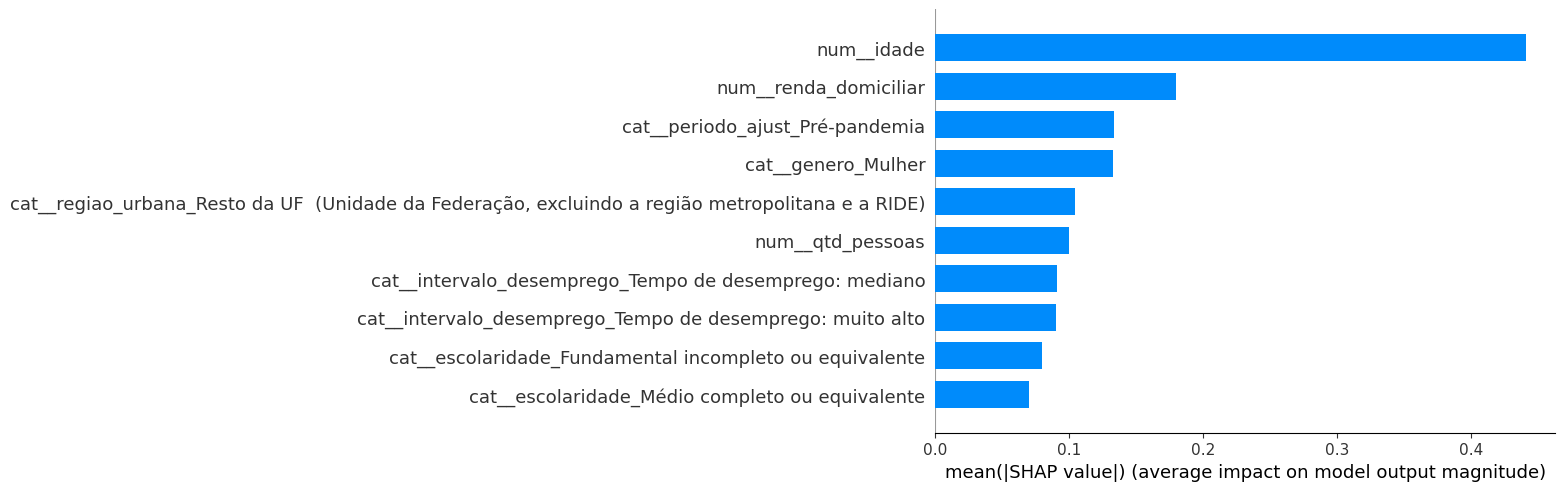

In [31]:
feature_names = preprocessor.get_feature_names_out()

shap.summary_plot(shap_values, features= x_test,
                  feature_names= feature_names,
                  plot_type="bar",
                 max_display = 10)

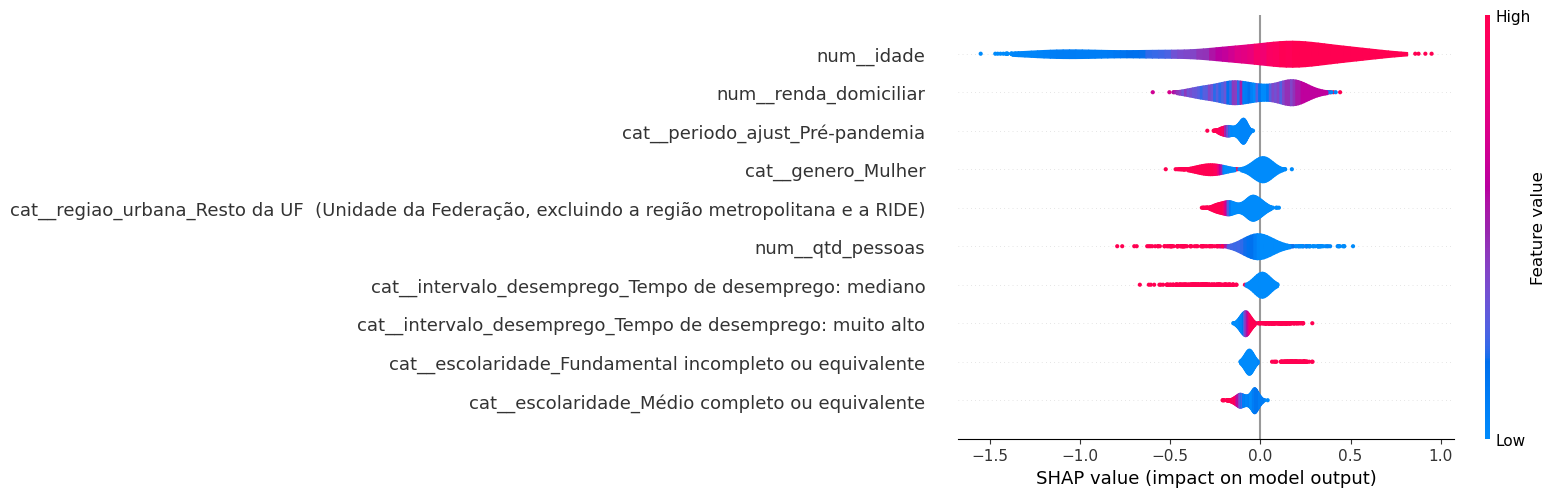

In [32]:
shap.summary_plot(shap_values, 
                  features=x_test.toarray(), # <--- A MUDANÇA PRINCIPAL ESTÁ AQUI
                  feature_names=feature_names,
                  plot_type="violin",
                  max_display=10)